In [42]:
import os
import speech_recognition as sr
import librosa
import librosa.display
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error

In [43]:
scale_record = StandardScaler()
scale_rerecord = StandardScaler()

In [44]:
def compute_mel_spectrogram(audio_signal, sample_rate):
    spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sample_rate)
    log_mel_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_mel_spectrogram

In [45]:
def compute_frequency_graph(audio_signal, sample_rate):
    frequency_graph = librosa.feature.mfcc(y=audio_signal, sr=sample_rate)
    return frequency_graph

In [46]:
def compute_pitch_graph(audio_signal, sample_rate):
    harmonic_audio_signal, _ = librosa.effects.hpss(y=audio_signal)
    pitch_graph = librosa.core.piptrack(y=harmonic_audio_signal, sr=sample_rate)[1]
    return pitch_graph

In [47]:
def record_voice(word, recordPath):
    r = sr.Recognizer()

    print(f"Please speak the word: {word}")
    print("Press Enter to start recording...")
    input()

    with sr.Microphone() as source:
        print("Recording...")
        audio = r.record(source, duration=3)  # Adjust the duration based on your preference

    # Save the recorded audio data to a file with the corresponding word name
    audio_file = recordPath + f"/{word}.wav"
    with open(audio_file, "wb") as f:
        f.write(audio.get_wav_data())

    # Convert the recorded audio data to an AudioData object
    audio_data = sr.AudioData(audio.get_wav_data(), sample_rate=audio.sample_rate, sample_width=audio.sample_width)

    # Compute frequency and pitch graphs
    audio_signal, sample_rate = librosa.load(audio_file)
    frequency_graph = compute_frequency_graph(audio_signal, sample_rate)
    pitch_graph = compute_pitch_graph(audio_signal, sample_rate)

    return audio_data, audio_file, frequency_graph, pitch_graph

In [48]:
def record_user_words(word_list):
    recorded_words = {}
    recordPath = "./recordPath"
    for word in word_list:
        while True:
            audio_data, audio_file, frequency_graph, pitch_graph = record_voice(word, recordPath)

            r = sr.Recognizer()
            try:
                # Perform speech recognition
                recognized_text = r.recognize_google(audio_data, language="en-US")
                recognized_text = recognized_text.lower()

                print("Recorded Word:", recognized_text)

                if recognized_text == word:
                    print("Recording Successful!")
                    recorded_words[word] = {
                        "frequency_graph": frequency_graph,
                        "pitch_graph": pitch_graph
                    }
                    break
                else:
                    print("Recording Failed! The recorded word does not match.")

                    # Prompt the user to switch the word
                    print(f"Do you want to switch the word '{word}'? (Y/N)")
                    choice = input()

                    if choice.lower() == "y":
                        # Ask for the new word
                        print("Enter the new word:")
                        new_word = input().lower()

                        recorded_words[new_word] = {
                            "frequency_graph": frequency_graph,
                            "pitch_graph": pitch_graph
                        }
                        break
                    else:
                        recorded_words[word] = {
                            "frequency_graph": frequency_graph,
                            "pitch_graph": pitch_graph
                        }
                        break

            except sr.UnknownValueError:
                print("Unable to recognize speech. Please try again.")
            except sr.RequestError:
                print("Speech recognition service is unavailable. Please try again.")

        print()

    return recorded_words

In [49]:
def re_record_user_words(word_list):
    re_recorded_words = {}
    recordPath = "./RerecordPath"

    for word in word_list:
        while True:
            audio_data, audio_file, frequency_graph, pitch_graph = record_voice(word, recordPath)

            r = sr.Recognizer()
            try:
                # Perform speech recognition by passing the AudioData object directly
                recognized_text = r.recognize_google(audio_data, language="en-US")
                recognized_text = recognized_text.lower()

                print("Recorded Word:", recognized_text)

                if recognized_text == word:
                    print("Re-recording Successful!")
                    re_recorded_words[word] = {
                        "frequency_graph": frequency_graph,
                        "pitch_graph": pitch_graph
                    }
                    break
                else:
                    print("Re-recording Failed! The recorded word does not match.")

                    # Prompt the user to re-record the word again
                    print(f"Do you want to re-record the word '{word}'? (Y/N)")
                    choice = input()

                    if choice.lower() == "n":
                        re_recorded_words[word] = {
                            "frequency_graph": frequency_graph,
                            "pitch_graph": pitch_graph
                        }
                        break

            except sr.UnknownValueError:
                print("Unable to recognize speech. Please try again.")
            except sr.RequestError:
                print("Speech recognition service is unavailable. Please try again.")

        print()

    return re_recorded_words

In [56]:
# def verify_recorded_words(recorded_words, re_recorded_words):
#     for recorded_word, re_recorded_word in zip(recorded_words.keys(), re_recorded_words.keys()):
#         # Load the audio signal for each word
#         audio_signal, sample_rate = librosa.load(f"./recordPath/{recorded_word}.wav")
#         re_audio_signal, re_sample_rate = librosa.load(f"./RerecordPath/{re_recorded_word}.wav")

#         # Compute mel spectrogram for the recorded word and the re-recorded word
#         mel_spectrogram_recorded = compute_mel_spectrogram(audio_signal, sample_rate)
#         mel_spectrogram_recorded_scaled = scale_record.fit_transform(mel_spectrogram_recorded)
#         print('mel_spectrogram_recorded\n',mel_spectrogram_recorded)
        
#         mel_spectrogram_re_recorded = compute_mel_spectrogram(re_audio_signal, re_sample_rate)
#         mel_spectrogram_re_recorded_scaled = scale_rerecord.fit_transform(mel_spectrogram_re_recorded)
#         print('mel_spectrogram_re_recorded\n',mel_spectrogram_re_recorded)

#         # Compare the mel spectrograms using Mean Absolute Error (MAE)
#         mae = mean_absolute_error(mel_spectrogram_recorded_scaled, mel_spectrogram_re_recorded_scaled)
        
#         print("mae", mae)
#         print(f"Verification for '{recorded_word}':")
#         if mae < 0.30:  # Adjust the threshold based on your requirement
#             print("Authentication Successful!")
#         else:
#             print("Authentication Failed!")


def compute_mfcc(audio_signal, sample_rate):
    # Compute MFCC
    mfcc_features = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=13)
    return mfcc_features

def dtw_distance(s1, s2):
    # Compute DTW distance between two sequences
    n, m = s1.shape[1], s2.shape[1]
    dtw_matrix = np.zeros((n, m))

    for i in range(n):
        for j in range(m):
            cost = euclidean(s1[:, i], s2[:, j])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])

    return dtw_matrix

def verify_recorded_words(recorded_words, re_recorded_words):
    for recorded_word, re_recorded_word in zip(recorded_words.keys(), re_recorded_words.keys()):
        # Load the audio signal for each word
        audio_signal, sample_rate = librosa.load(f"./recordPath/{recorded_word}.wav")
        re_audio_signal, re_sample_rate = librosa.load(f"./RerecordPath/{re_recorded_word}.wav")

        # Compute MFCC for the recorded word and the re-recorded word
        mfcc_recorded = compute_mfcc(audio_signal, sample_rate)
        print('audio_signal',audio_signal)
        print('sample_rate',sample_rate)
        mfcc_re_recorded = compute_mfcc(re_audio_signal, re_sample_rate)
        print('re_audio_signal',re_audio_signal)
        print('re_sample_rate',re_sample_rate)
        # Compute DTW distance between MFCC sequences
        dtw_matrix = dtw_distance(mfcc_recorded, mfcc_re_recorded)
        print('dtw_matrix',dtw_matrix)

        # Find peaks in the DTW distance to align the sequences
        peaks, _ = find_peaks(-dtw_matrix[-1, :], distance=50)

        print(f"Verification for '{recorded_word}':")
        if len(peaks) > 0:  # Adjust the threshold based on your requirement
            print("Authentication Successful!")
        else:
            print("Authentication Failed!")

# The rest of the code remains unchanged

In [57]:
if __name__ == "__main__":
    word_list = ["kunal", "honest"]

    recorded_words = record_user_words(word_list)
    re_recorded_words = re_record_user_words(recorded_words)

    print("\nRecorded Words:")
    for word in re_recorded_words:
        print(word)

    print("\nVerification:")
    verify_recorded_words(recorded_words, re_recorded_words)

Please speak the word: kunal
Press Enter to start recording...



ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.front
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround40
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround41
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround50
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround51
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround71
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2664:(snd

Recording...
Recorded Word: kunal
Recording Successful!

Please speak the word: honest
Press Enter to start recording...



ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.front
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround40
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround41
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround50
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround51
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround71
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2664:(snd

Recording...
Recorded Word: honest
Recording Successful!

Please speak the word: kunal
Press Enter to start recording...



ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.front
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround40
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround41
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround50
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround51
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround71
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2664:(snd

Recording...
Recorded Word: kunal
Re-recording Successful!

Please speak the word: honest
Press Enter to start recording...



ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.front
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround40
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround41
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround50
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround51
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround71
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2664:(snd

Recording...
Recorded Word: honest
Re-recording Successful!


Recorded Words:
kunal
honest

Verification:
audio_signal [-1.0913936e-11 -9.0949470e-12 -7.2759576e-12 ... -1.0305583e-03
 -3.3291755e-03 -6.1808033e-03]
sample_rate 22050
re_audio_signal [1.8189894e-12 1.8189894e-12 1.8189894e-12 ... 2.6376247e-02 2.7671013e-02
 2.4966076e-02]
re_sample_rate 22050
dtw_matrix [[   29.52959061    29.14609718    29.15346527 ...   409.08691406
    396.36602783   364.22235107]
 [   30.23225403    58.52578354    58.34750748 ...   817.19223022
    791.72006226   727.42855835]
 [   30.12225151    59.45099258    87.52167702 ...  1225.42294312
   1187.20336914  1090.76443481]
 ...
 [  386.14987183   764.58831787  1141.22412109 ... 10103.03195953
  10139.18556595 10082.50385857]
 [  385.32778931   769.35247803  1148.10534668 ... 10113.02485275
  10150.58774567 10113.51931953]
 [  357.69696045   713.9828186   1069.7199707  ... 10153.16514969
  10188.01573563 10162.12228966]]
Verification for 'kunal':
A

In [16]:
# !pip install librosa numpy scipy
import librosa

def extract_mfcc_features(audio_file):
    # Load audio file and extract MFCC features
    y, sr = librosa.load(audio_file)
    mfcc_features = librosa.feature.mfcc(y=y, sr=sr)
    return mfcc_features


In [17]:
wav_file1 = "/home/om_prakash/Desktop/voice otp assignment/RerecordPath/coding.wav"
wav_file2 = "/home/om_prakash/Desktop/voice otp assignment/recordPath/coding.wav"

features1 = extract_mfcc_features(wav_file1)
features2 = extract_mfcc_features(wav_file2)


In [22]:
import librosa
from scipy.spatial import distance

def extract_mfcc_features(audio_file):
    # Load audio file and extract MFCC features
    y, sr = librosa.load(audio_file)
    mfcc_features = librosa.feature.mfcc(y=y, sr=sr)
    return mfcc_features

def cosine_similarity(x, y):
    # Flatten the 2D feature arrays to 1D
    x_flat = x.flatten()
    y_flat = y.flatten()
    return 1 - distance.cosine(x_flat, y_flat)

# Assuming you have two WAV files for the same word from the same person
wav_file1 = "/home/om_prakash/Desktop/voice otp assignment/RerecordPath/coding.wav"
wav_file2 = "/home/om_prakash/Desktop/voice otp assignment/recordPath/coding.wav"

features1 = extract_mfcc_features(wav_file1)
features2 = extract_mfcc_features(wav_file2)

# Choose a similarity measure and set a threshold
similarity_score = cosine_similarity(features1, features2)
# or
# similarity_score = euclidean_distance(features1, features2)

threshold = 0.9  # Set your desired threshold here

if similarity_score > threshold:
    print("The two WAV files belong to the same speaker.")
else:
    print("The two WAV files belong to different speakers.")


The two WAV files belong to the same speaker.


In [4]:
# !pip install pyAudioAnalysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 3.1 MB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264373 sha256=beeec207378b7c48530e9255736476595183ba410815567bc1110429b1f85841
  Stored in directory: /home/om_prakash/.cache/pip/wheels/16/fd/d4/2e6c5f85d8f8238265885c9555e724242474a9e2024b21c8e5
Successfully built pyAudioAnalysis


In [12]:
# import glob
# import aifc
# import eyed3
# import ntpath
# import shutil
# import pydub

In [7]:
# !pip install eyed3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 10.0 MB/s eta 0:00:00


In [11]:
# !pip install pydub

/home/om_prakash/anaconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


AttributeError: module 'matplotlib' has no attribute 'axes'

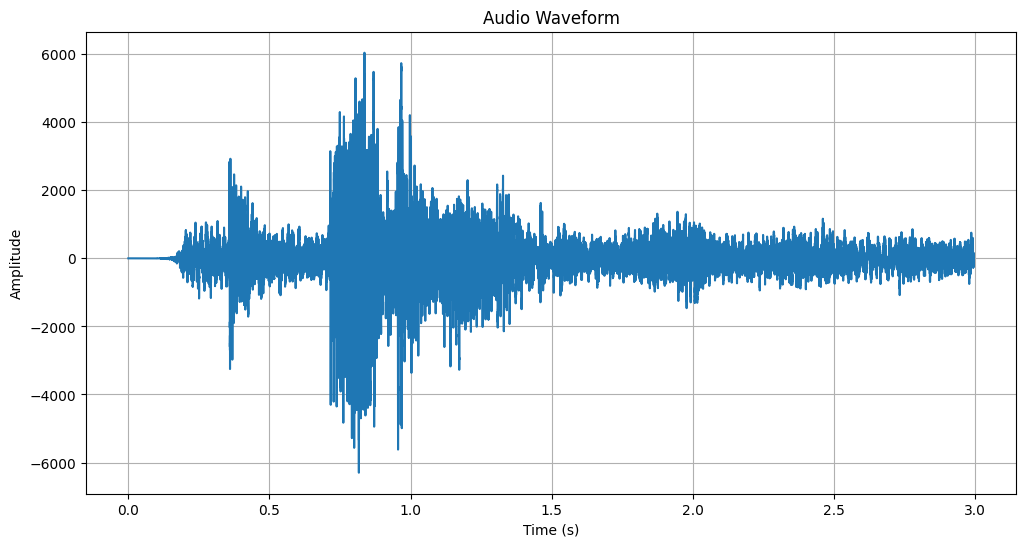

<Figure size 1200x600 with 0 Axes>

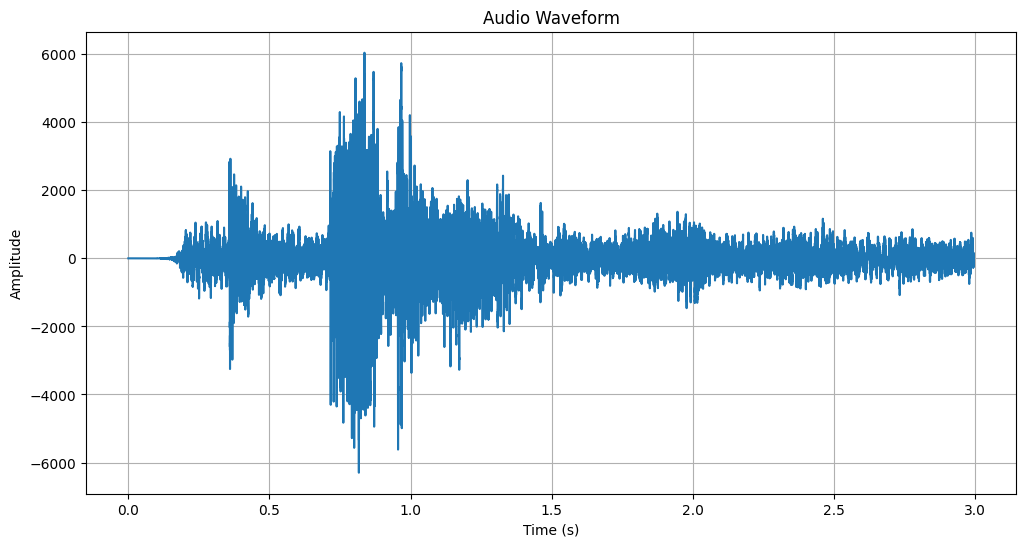

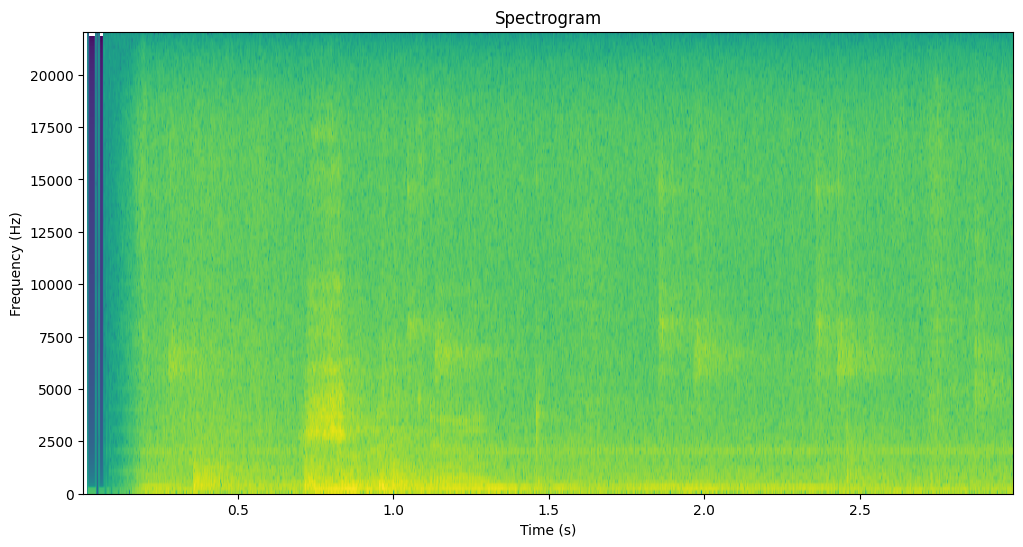

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [30]:
plt.figure(figsize=(12, 6))
plt.specgram(data, Fs=sample_rate)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar()
plt.show()

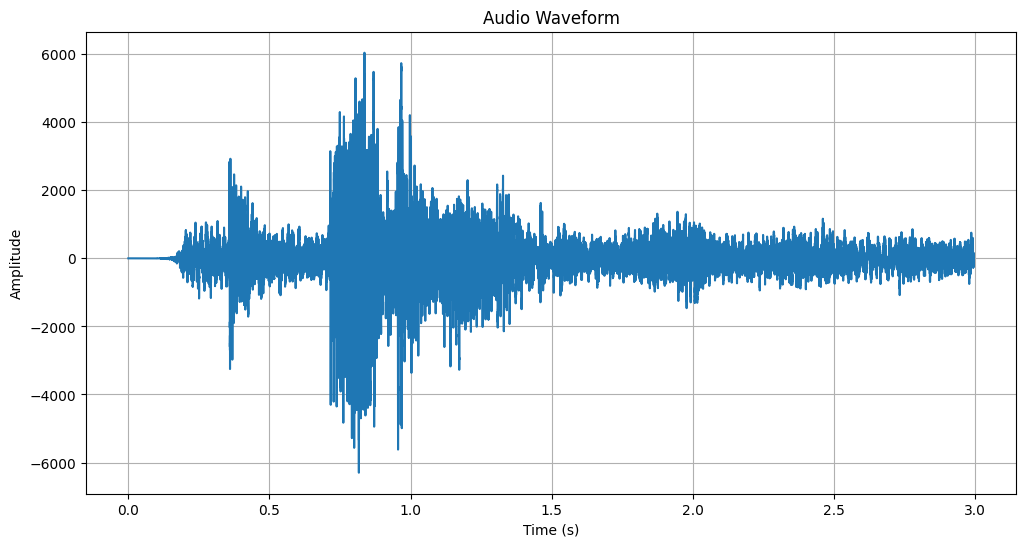

<Figure size 1200x600 with 0 Axes>

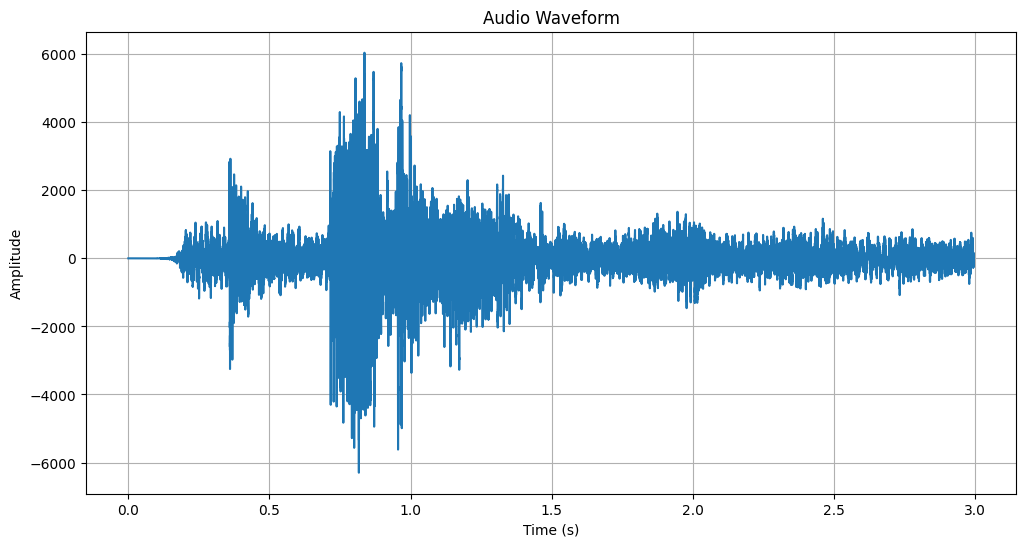

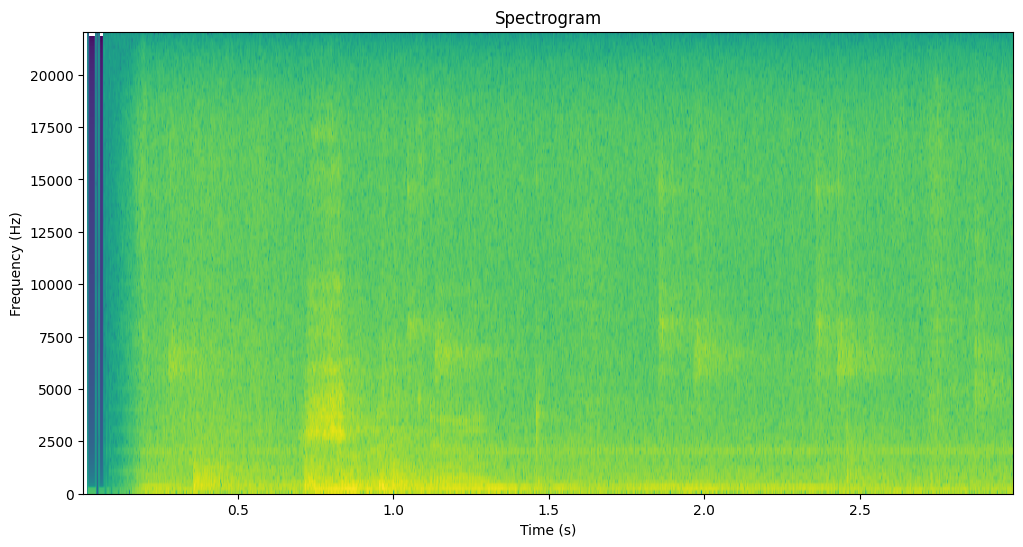

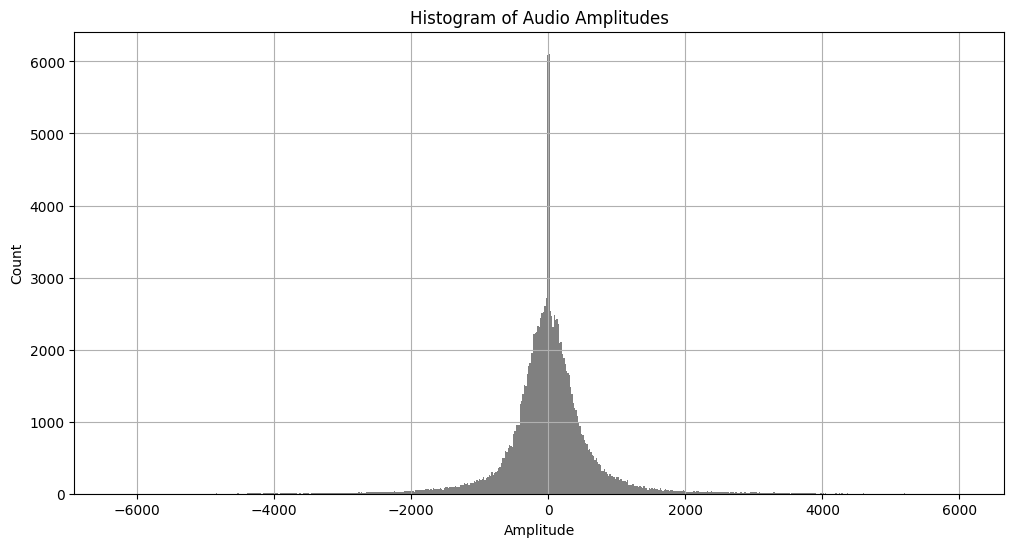

AttributeError: module 'matplotlib' has no attribute 'pyplot'

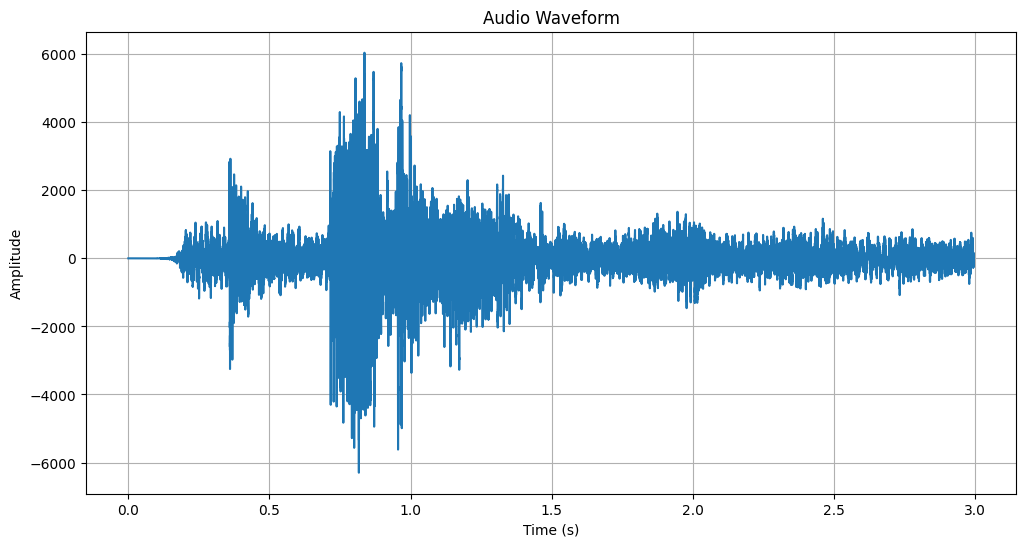

<Figure size 1200x600 with 0 Axes>

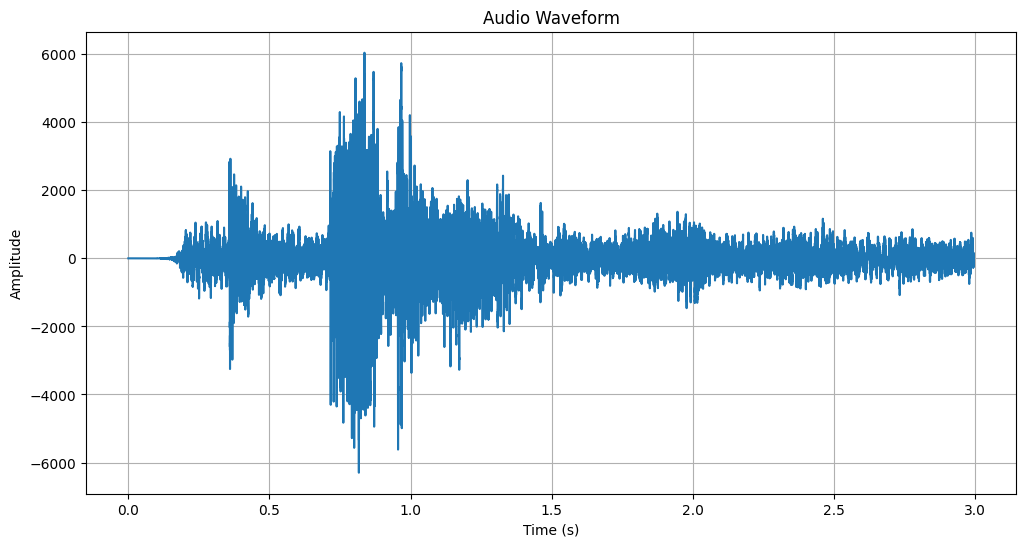

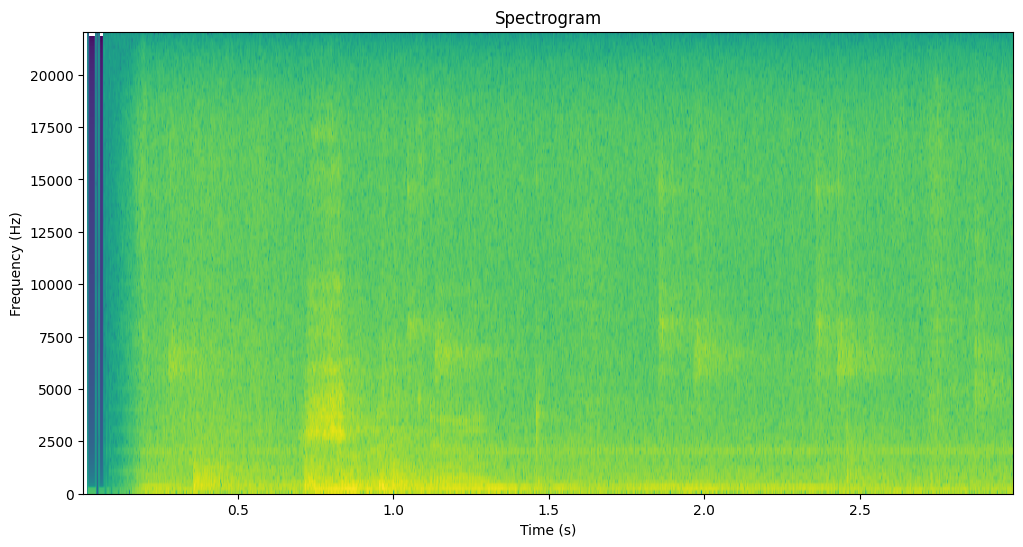

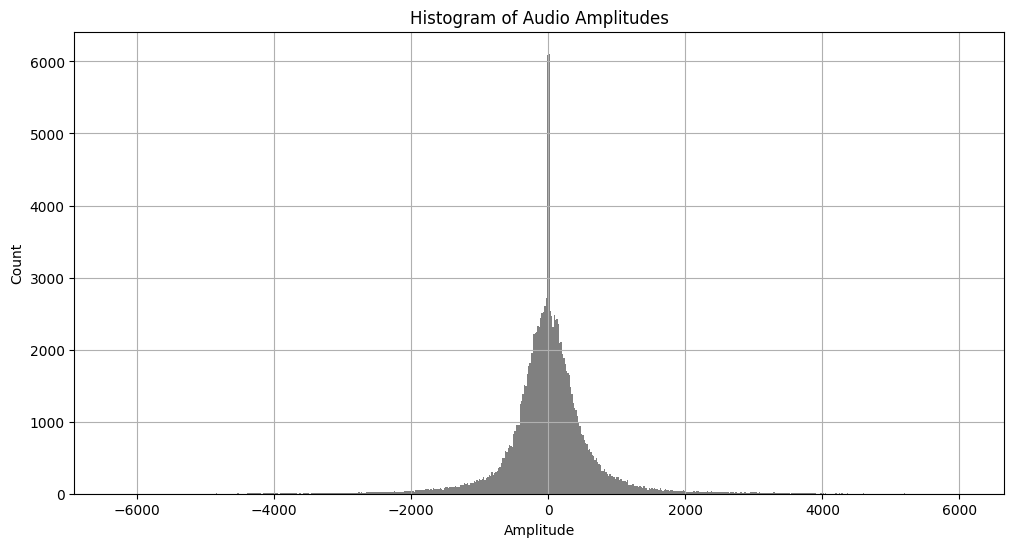

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [31]:
plt.figure(figsize=(12, 6))
plt.hist(data, bins='auto', color='gray')
plt.xlabel('Amplitude')
plt.ylabel('Count')
plt.title('Histogram of Audio Amplitudes')
plt.grid()
plt.show()

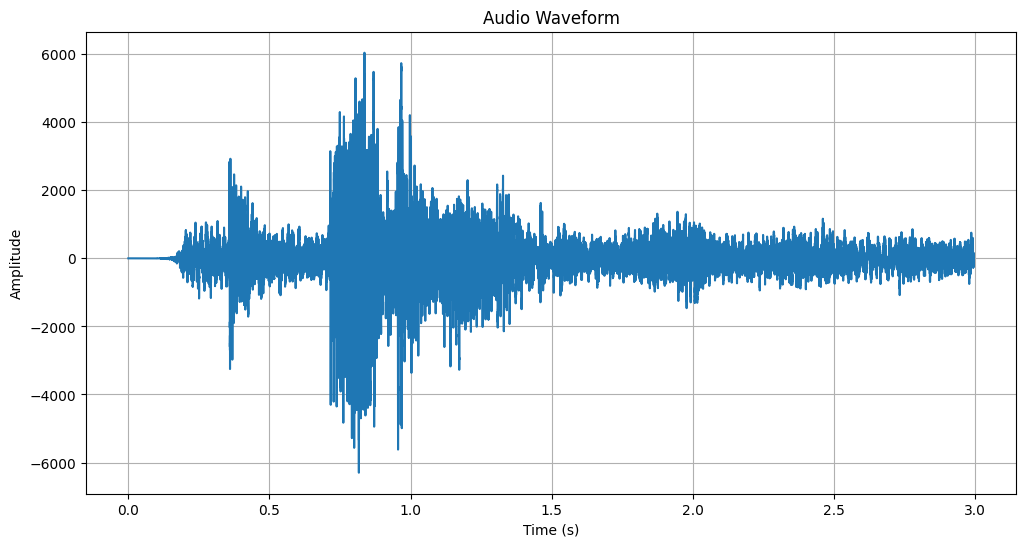

<Figure size 1200x600 with 0 Axes>

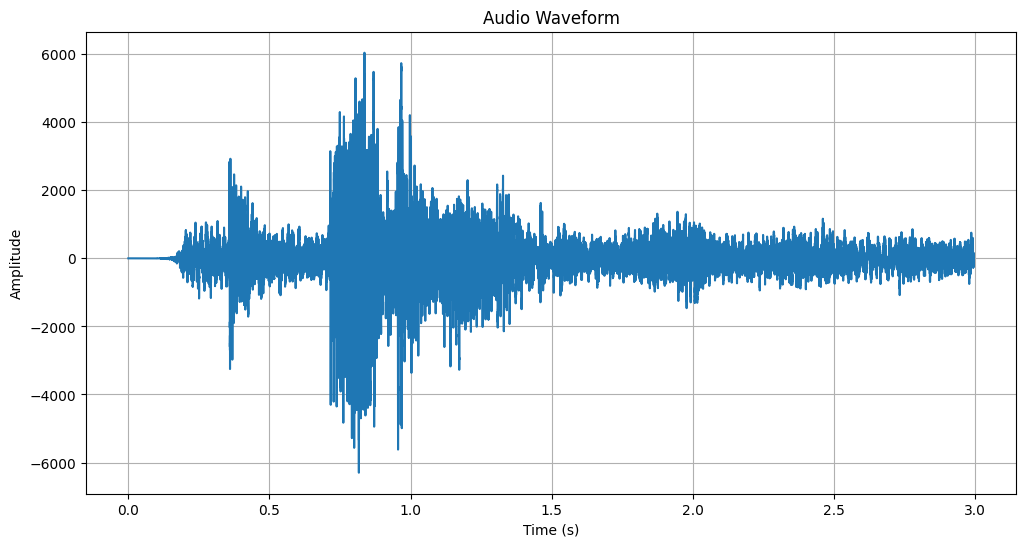

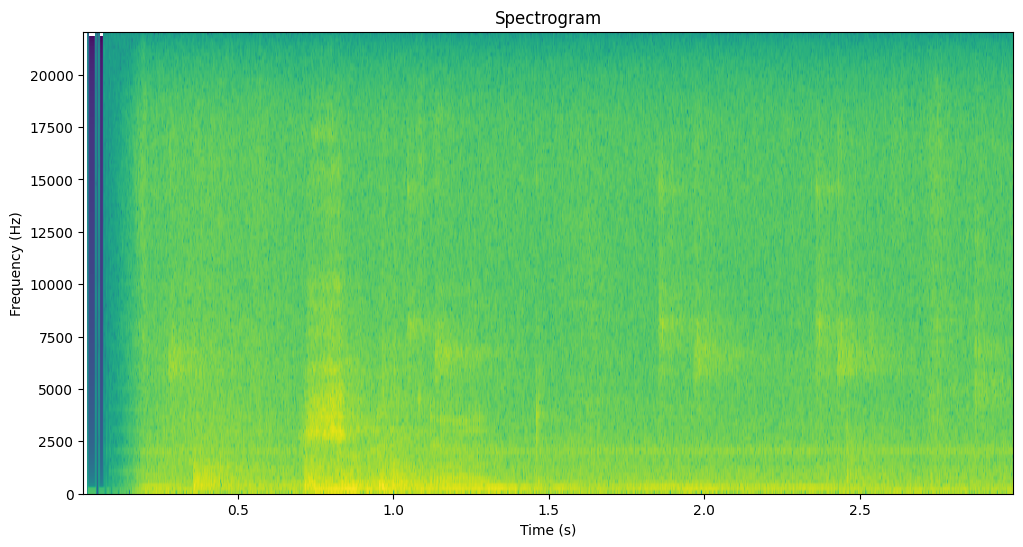

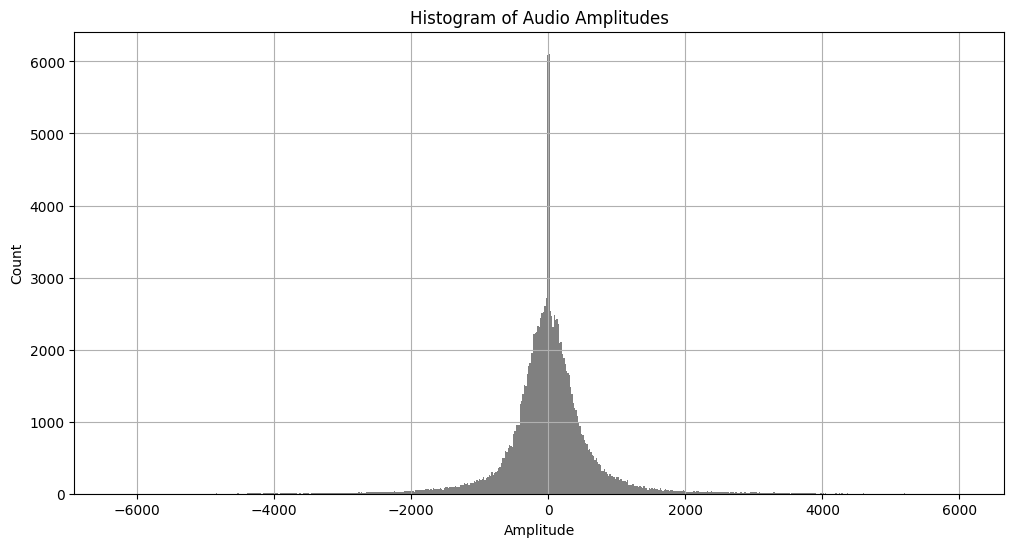

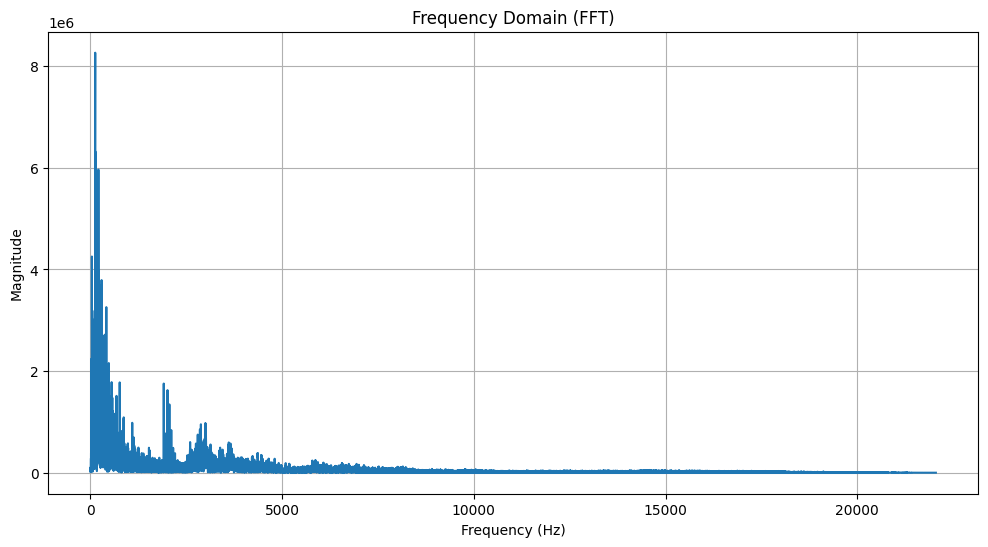

AttributeError: module 'matplotlib' has no attribute 'pyplot'

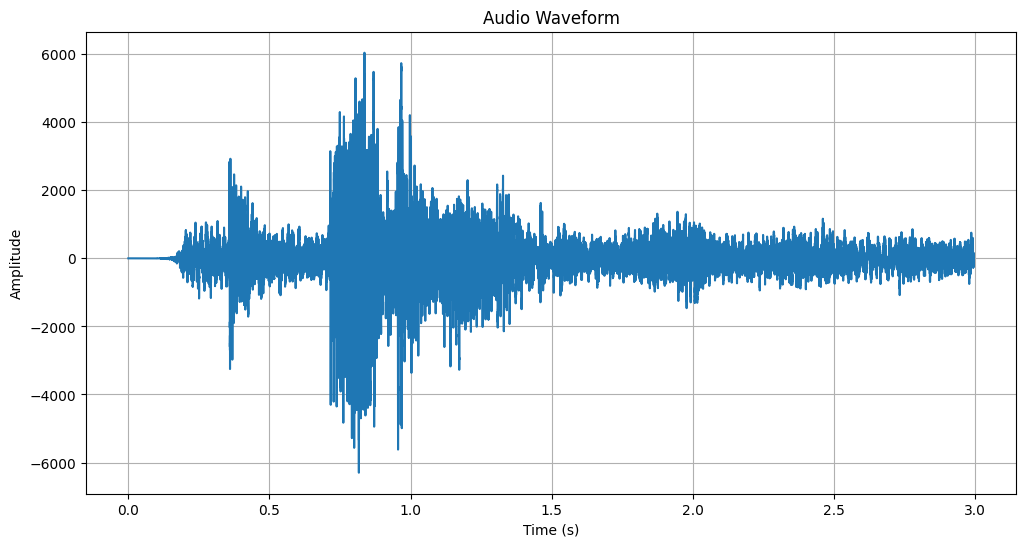

<Figure size 1200x600 with 0 Axes>

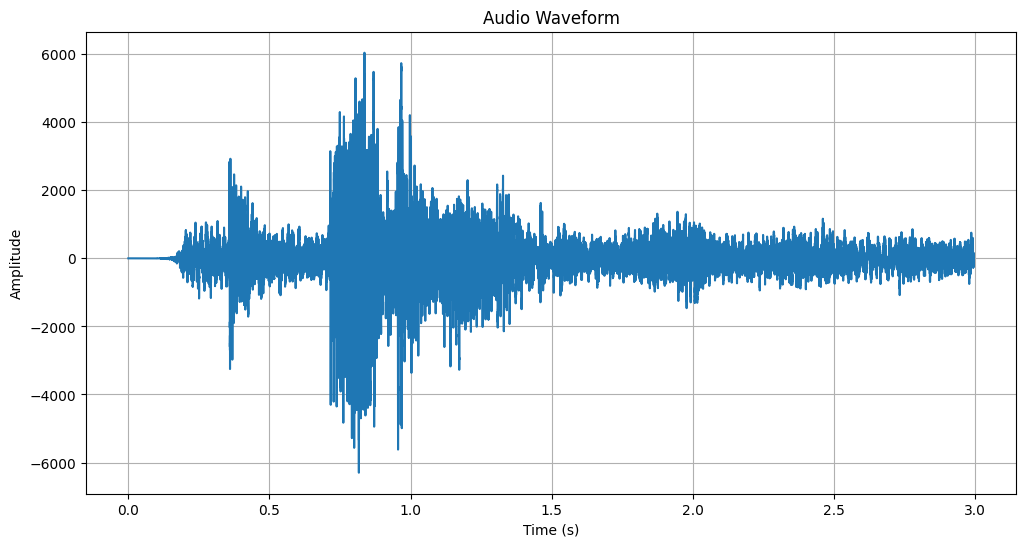

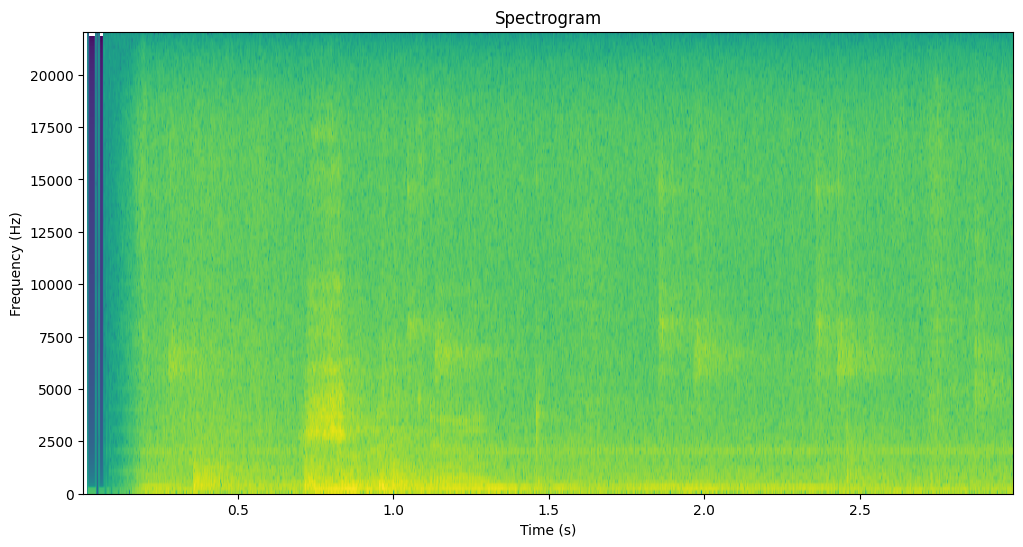

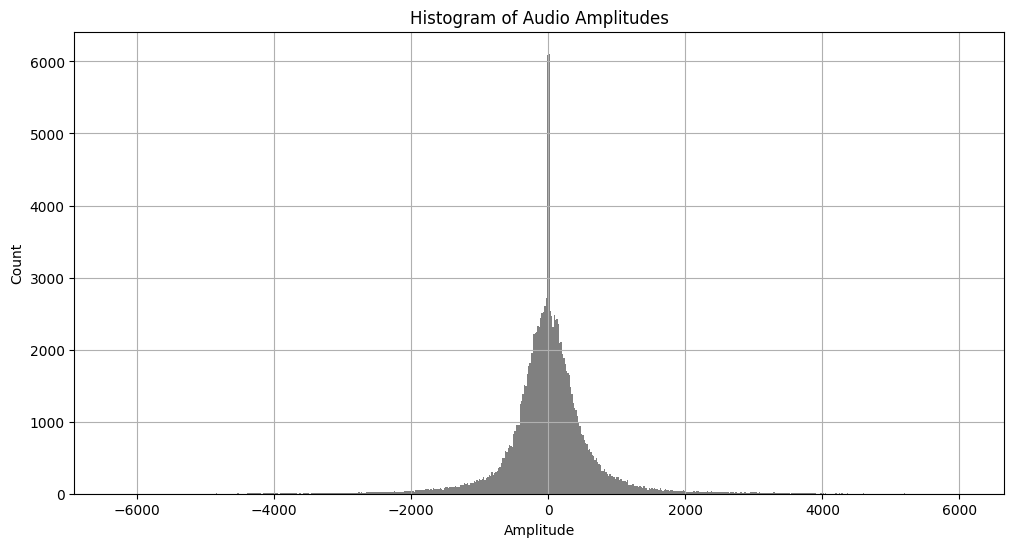

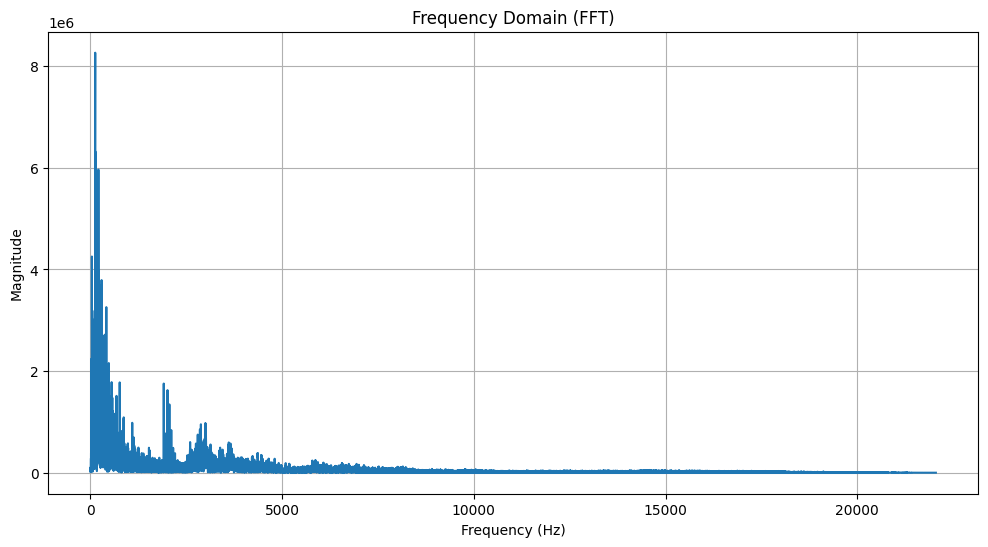

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [32]:
fft_data = np.fft.fft(data)
freq = np.fft.fftfreq(num_samples, 1.0 / sample_rate)
plt.figure(figsize=(12, 6))
plt.plot(freq[:num_samples // 2], np.abs(fft_data)[:num_samples // 2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Domain (FFT)')
plt.grid()
plt.show()


In [36]:
# Install virtualenv if you haven't already
# !pip install virtualenv

# Create a new virtual environment
# virtualenv my_env

# Activate the virtual environment
# On Windows:
# my_env\Scripts\activate
# On macOS/Linux:
# source my_env/bin/activate

# Now install the required libraries
# pip install numpy scipy matplotlib


SyntaxError: invalid syntax (1003771031.py, line 5)

In [64]:
import random

import numpy as np

from audio import read_mfcc
from batcher import sample_from_mfcc
from constants import SAMPLE_RATE, NUM_FRAMES
from conv_models import DeepSpeakerModel
from test import batch_cosine_similarity

ModuleNotFoundError: No module named 'audio'

In [65]:
 conda install -c anaconda audio 

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - audio

Current channels:

  - https://conda.anaconda.org/anaconda/linux-64
  - https://conda.anaconda.org/anaconda/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [66]:
git init
git remote add origin https://github.com/ommnnitald/voice-biometric-authentication


SyntaxError: invalid syntax (632177554.py, line 1)